<a href="https://colab.research.google.com/github/minhyeok2001/Computer-Vision/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT 만들기

## 데이터 준비

- 사실 좀 걱정인게, transformer 모델은 다른 cnn 계열에 비해 넣는 데이터셋 수가 정말정말 많아야한다고 함 ( 논문 인용.. )

- 데이터가 모자라다는 imageNet도 138GB ..
- ***일단 성능보다는 모델 구조만 잘 잡고간다는 생각으로 해보기***

In [1]:
import ssl
import torch
import torch.nn as nn
from torchvision import transforms, datasets

train_dataset = datasets.CIFAR10(root="./data/",train=True,download=True,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = datasets.CIFAR10(root="./data/",train=False,download=True,transform=transforms.Compose([transforms.ToTensor()]))


100%|██████████| 170M/170M [00:02<00:00, 70.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [2]:
print(train_dataset[1])
print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[0][0].shape)

(tensor([[[0.6039, 0.4941, 0.4118,  ..., 0.3569, 0.3412, 0.3098],
         [0.5490, 0.5686, 0.4902,  ..., 0.3765, 0.3020, 0.2784],
         [0.5490, 0.5451, 0.4510,  ..., 0.3098, 0.2667, 0.2627],
         ...,
         [0.6863, 0.6118, 0.6039,  ..., 0.1647, 0.2392, 0.3647],
         [0.6471, 0.6118, 0.6235,  ..., 0.4039, 0.4824, 0.5137],
         [0.6392, 0.6196, 0.6392,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.6941, 0.5373, 0.4078,  ..., 0.3725, 0.3529, 0.3176],
         [0.6275, 0.6000, 0.4902,  ..., 0.3882, 0.3137, 0.2863],
         [0.6078, 0.5725, 0.4510,  ..., 0.3216, 0.2745, 0.2706],
         ...,
         [0.6549, 0.6039, 0.6275,  ..., 0.1333, 0.2078, 0.3255],
         [0.6039, 0.5961, 0.6314,  ..., 0.3647, 0.4471, 0.4745],
         [0.5804, 0.5804, 0.6118,  ..., 0.5216, 0.5255, 0.5216]],

        [[0.7333, 0.5333, 0.3725,  ..., 0.2784, 0.2784, 0.2745],
         [0.6627, 0.6039, 0.4627,  ..., 0.3059, 0.2431, 0.2392],
         [0.6431, 0.5843, 0.4392,  ..., 0.2510, 0.2157, 0

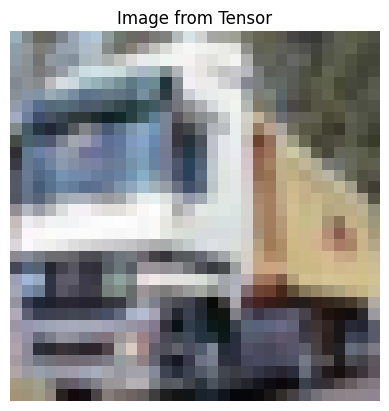

In [3]:
import matplotlib.pyplot as plt

image_tensor, label = train_dataset[1]
data_np = image_tensor.numpy()
plt.imshow(data_np.transpose(1, 2, 0))
plt.axis('off')
plt.title("Image from Tensor")
plt.show()

- train_dataset 어떻게 생겼는지 다시보기

In [4]:
print(train_dataset[0]) # 앞에는 이미지, 뒤에는 클래스 나와있음. [0][0] 출력하면 3x32x32 나오는걸 생각해보면 좋을듯

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0

- val 데이터 나눠주기
- 이렇게 되면 train / valid / test : 45000, 5000, 10000

In [5]:
from sklearn.model_selection import train_test_split

train_dataset, valid_dataset = train_test_split(train_dataset,test_size=0.1,random_state=42)
print(len(train_dataset),len(valid_dataset))

45000 5000


- 데이터로더 올리기

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

- 데이터로더 확인

In [7]:
for input,label in train_loader:
  print(input)
  print(label)
  break

tensor([[[[0.2431, 0.2824, 0.2510,  ..., 0.1647, 0.1922, 0.1647],
          [0.2902, 0.2980, 0.2745,  ..., 0.1451, 0.1647, 0.1686],
          [0.2941, 0.3059, 0.2863,  ..., 0.1765, 0.1843, 0.1961],
          ...,
          [0.1647, 0.1490, 0.1765,  ..., 0.5098, 0.5490, 0.5176],
          [0.2235, 0.2078, 0.1373,  ..., 0.5176, 0.5451, 0.4549],
          [0.4510, 0.3451, 0.1412,  ..., 0.4902, 0.5059, 0.3608]],

         [[0.2784, 0.2941, 0.2588,  ..., 0.1608, 0.1922, 0.1725],
          [0.3216, 0.3098, 0.2824,  ..., 0.1490, 0.1686, 0.1804],
          [0.3216, 0.3137, 0.2863,  ..., 0.1804, 0.1961, 0.2118],
          ...,
          [0.1725, 0.1529, 0.1804,  ..., 0.5686, 0.6000, 0.5490],
          [0.2314, 0.2118, 0.1412,  ..., 0.5686, 0.5804, 0.4745],
          [0.4588, 0.3490, 0.1451,  ..., 0.5137, 0.5137, 0.3647]],

         [[0.1882, 0.2118, 0.1725,  ..., 0.1098, 0.1216, 0.0784],
          [0.2196, 0.2157, 0.1882,  ..., 0.0980, 0.1020, 0.0863],
          [0.2118, 0.2157, 0.1961,  ..., 0

## ViT 구현하기

- architecture

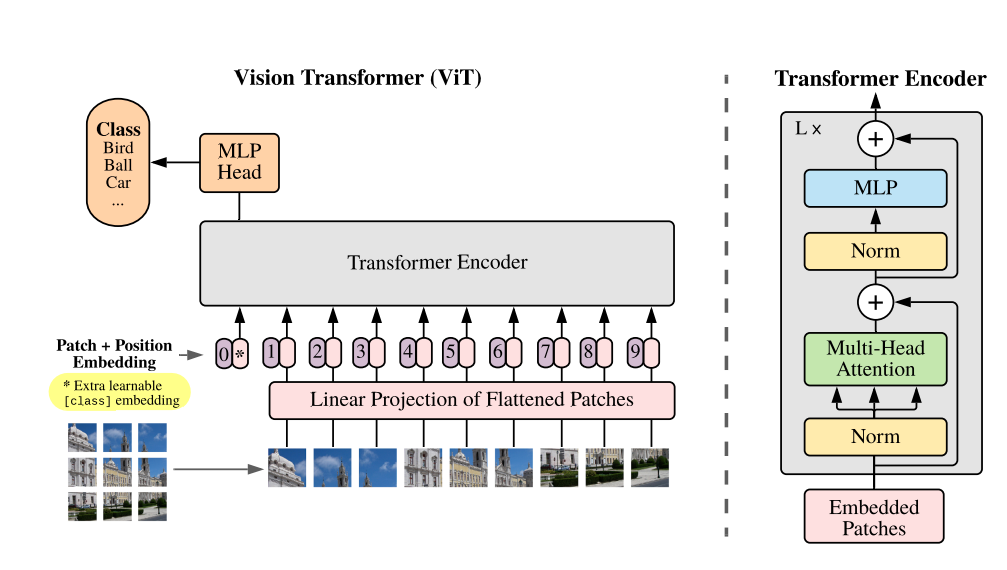

- 요소
  - input_to_embedding
    - linear projection
    - position embedding + class token
  - transformer_encoder
    - norm
    - MHA -> mask x ( encoder only )
    - norm
    - MLP

### Input to embedding

- 일단 patch 크기는 fixed, patch 개수는 유동

In [8]:
## input 예시
print(train_dataset[0][0].shape) ## channel x width x height

torch.Size([3, 32, 32])


- Q. 혹시 채널은 어떻게 핸들링하나요? linear projection시에 ??
  - A. 아래 논문 글을 가져왔음. 정리하자면, 채널은 그대로 살리는듯

> To handle 2D images, we reshape the image x 2 RH⇥W⇥C into a
sequence of flattened 2D patches xp 2 RN⇥(P 2·C)
, where (H,W) is the resolution of the original
image, C is the number of channels, (P, P) is the resolution of each image patch, and N = HW/P2
is the resulting number of patches, which also serves as the effective input sequence length for the
Transformer.



- Q. 혹시 정확한 과정이 어떻게 되는건가요?? 이미지 텐서화(projection) -> 이거에 맞는 embedding 설정 -> 그다음 class token 붙이기?
 아니면 class token 붙이고 embedding ??
  - A. 임베딩 하고 클래스토큰 붙이고 그다음 position embedding 더하기

- Q. 논문에서는 position embedding이 fixed value or learnable params라고 했음. 이때 만약 파라미터라면, 초기값을 어떻게 설정해야할지??? 그냥 Gaussian이나 Xavier같은 init을 사용하는게 맞는건지 생각해봐야 하지 않나? 개인적으로는 차라리 0 1 2 3 4 .. 이런식으로 초기화해놓는게 직관적으로 더 좋을거같은데.
  - A. 이거는 정답이 있다기보다는, 나는 이렇게 그냥 해보는걸로 하자. torch.linspace를 통해서 균등하게 자를 수 있음

- Q. position embedding은 혹시 차원이 embedding하고 동일한 차원을 가져야하는지?
  - A. 네 맞아요.

- Q. 실제 ViT 코드 보면, position embedding에서는 배치 고려 안하는데, cls는 배치 고려 함. 왜그런거에요???
  - A. 사실 고려 한거임. 아래에서 torch.add 함수를 볼 수 있는데, 이게 dim이 완전히 동일하지 않아도, 뒷부분 동일하면 알아서 그만큼 복제해서 ( 즉 배치사이즈만큼 ) 더해줌 !!

**주의 !!!**
- 만약 배치 사이즈를 알아야한다면, forward 함수 처음에 x.shape을 통해서 알아내기 !!!!

In [11]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00


In [12]:
import torch.nn as nn
from einops import rearrange
from einops import repeat
## input으로 사진이 들어갈거고, 사진을 적절히 패치사이즈로 쪼개서 보내주기

## 우리 모두 동일한 크기의 정사각형 이미지가 들어온다고 가정하자

## 입력으로부터 embedding까지 과정 : input to embedding 클래스로 선언
class input_to_embedding(nn.Module):
  def __init__(self,channel=3,width=32,height=32,patch_size=4,embedding_dim=4*4*3):
    super().__init__()
    self.patch_size = patch_size
    self.embedding_dim = embedding_dim
    self.num_patches = (width//patch_size) * (height//patch_size)


    ## 1. 패치 자르기. 원래 들어오는거는 batch x 3 x 32 x 32 이고 패치 사이즈가 4라면 -> batch x 64 x (4 4 3)
    # self.rearrange

    ## 2. 자른 패치를 embedding 시켜주기
    self.linear = nn.Linear(channel*patch_size*patch_size, embedding_dim)

    ## 3. class 토큰 더해주기
    self.cls = nn.Parameter(torch.randn(1,1,embedding_dim)) ## batch, patch 개수, patch_size와 동일한 dim을 가지는 cls

    ## 4. position_embedding 더해주기 -> 이거는 랜덤 초기화 좀 힘든데....
    self.positions = torch.linspace(-1, 1, steps=self.num_patches+1).unsqueeze(1)  ## 이렇게하면 dim : ( patch 개수+1, 1 ) < 1 더하는거는 cls 때문
    self.position_embedding = nn.Parameter(self.positions.repeat(1, embedding_dim)) ## 이렇게 하면 dim : (patch 개수+1, embedding_dim)


  def forward(self,x):
    batch,_,__,__= x.shape

    x = rearrange(x, pattern='b c (num_w p1)(num_h p2) -> b (num_w num_h)(p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
    x = self.linear(x)
    ## cls dim : 1,1,48
    ## x dim : batch ,1, 48
    ## 즉 cls를 batch 사이즈만큼 복제시켜야함
    batch_cls = repeat(self.cls, pattern='() n d -> b n d', b=batch)

    x = torch.cat((batch_cls,x),dim=1) ## patch 개수 의미하는 dim 방향으로
    x = torch.add(x,self.position_embedding) ## torch.add의 broadcasting을 이용해서 자동으로 모든 배치에 대해서 더해짐
    #print(x.shape)
    return x



In [ ]:
test_positions = torch.linspace(-1, 1, steps=32).unsqueeze(1)  ## 이렇게하면 dim : ( patch 개수, 1 )
print(test_positions.shape)

### Transformer Encoder

- Q. batch norm 적용시키려고 보니, 이게 과연 batchnorm 2D를 쓰는게 맞을까? + 왜 batchnorm을 쓰시나요? -> activation function 들어가기전에 분포를 고르게(non-linear 하면서..) 만들어주기 위해서임. 근데 activation ft가 있어요?
  - A. 논문에서 사용한 norm은 layerNorm이랍니다.

- Q. layerNorm도 결국 동일한거 아닌가요? 이것도 act ft때문에 해주는거 아닌가?? 근데 왜 붙이는거??
  - A.  "On the Expressivity Role of LayerNorm in Transformers’ Attention" 논문을 확인해보면, MHA 내부에서의 표현력이 좋아진다고 함..
  https://m.blog.naver.com/jjunsss/223229403388?utm_source=chatgpt.com

- Q. 막상 해보려니 잘 안되는데.. 이거 헤드단위로 병렬처리 어떻게 시키지?? -> 정리한번 하고 가보자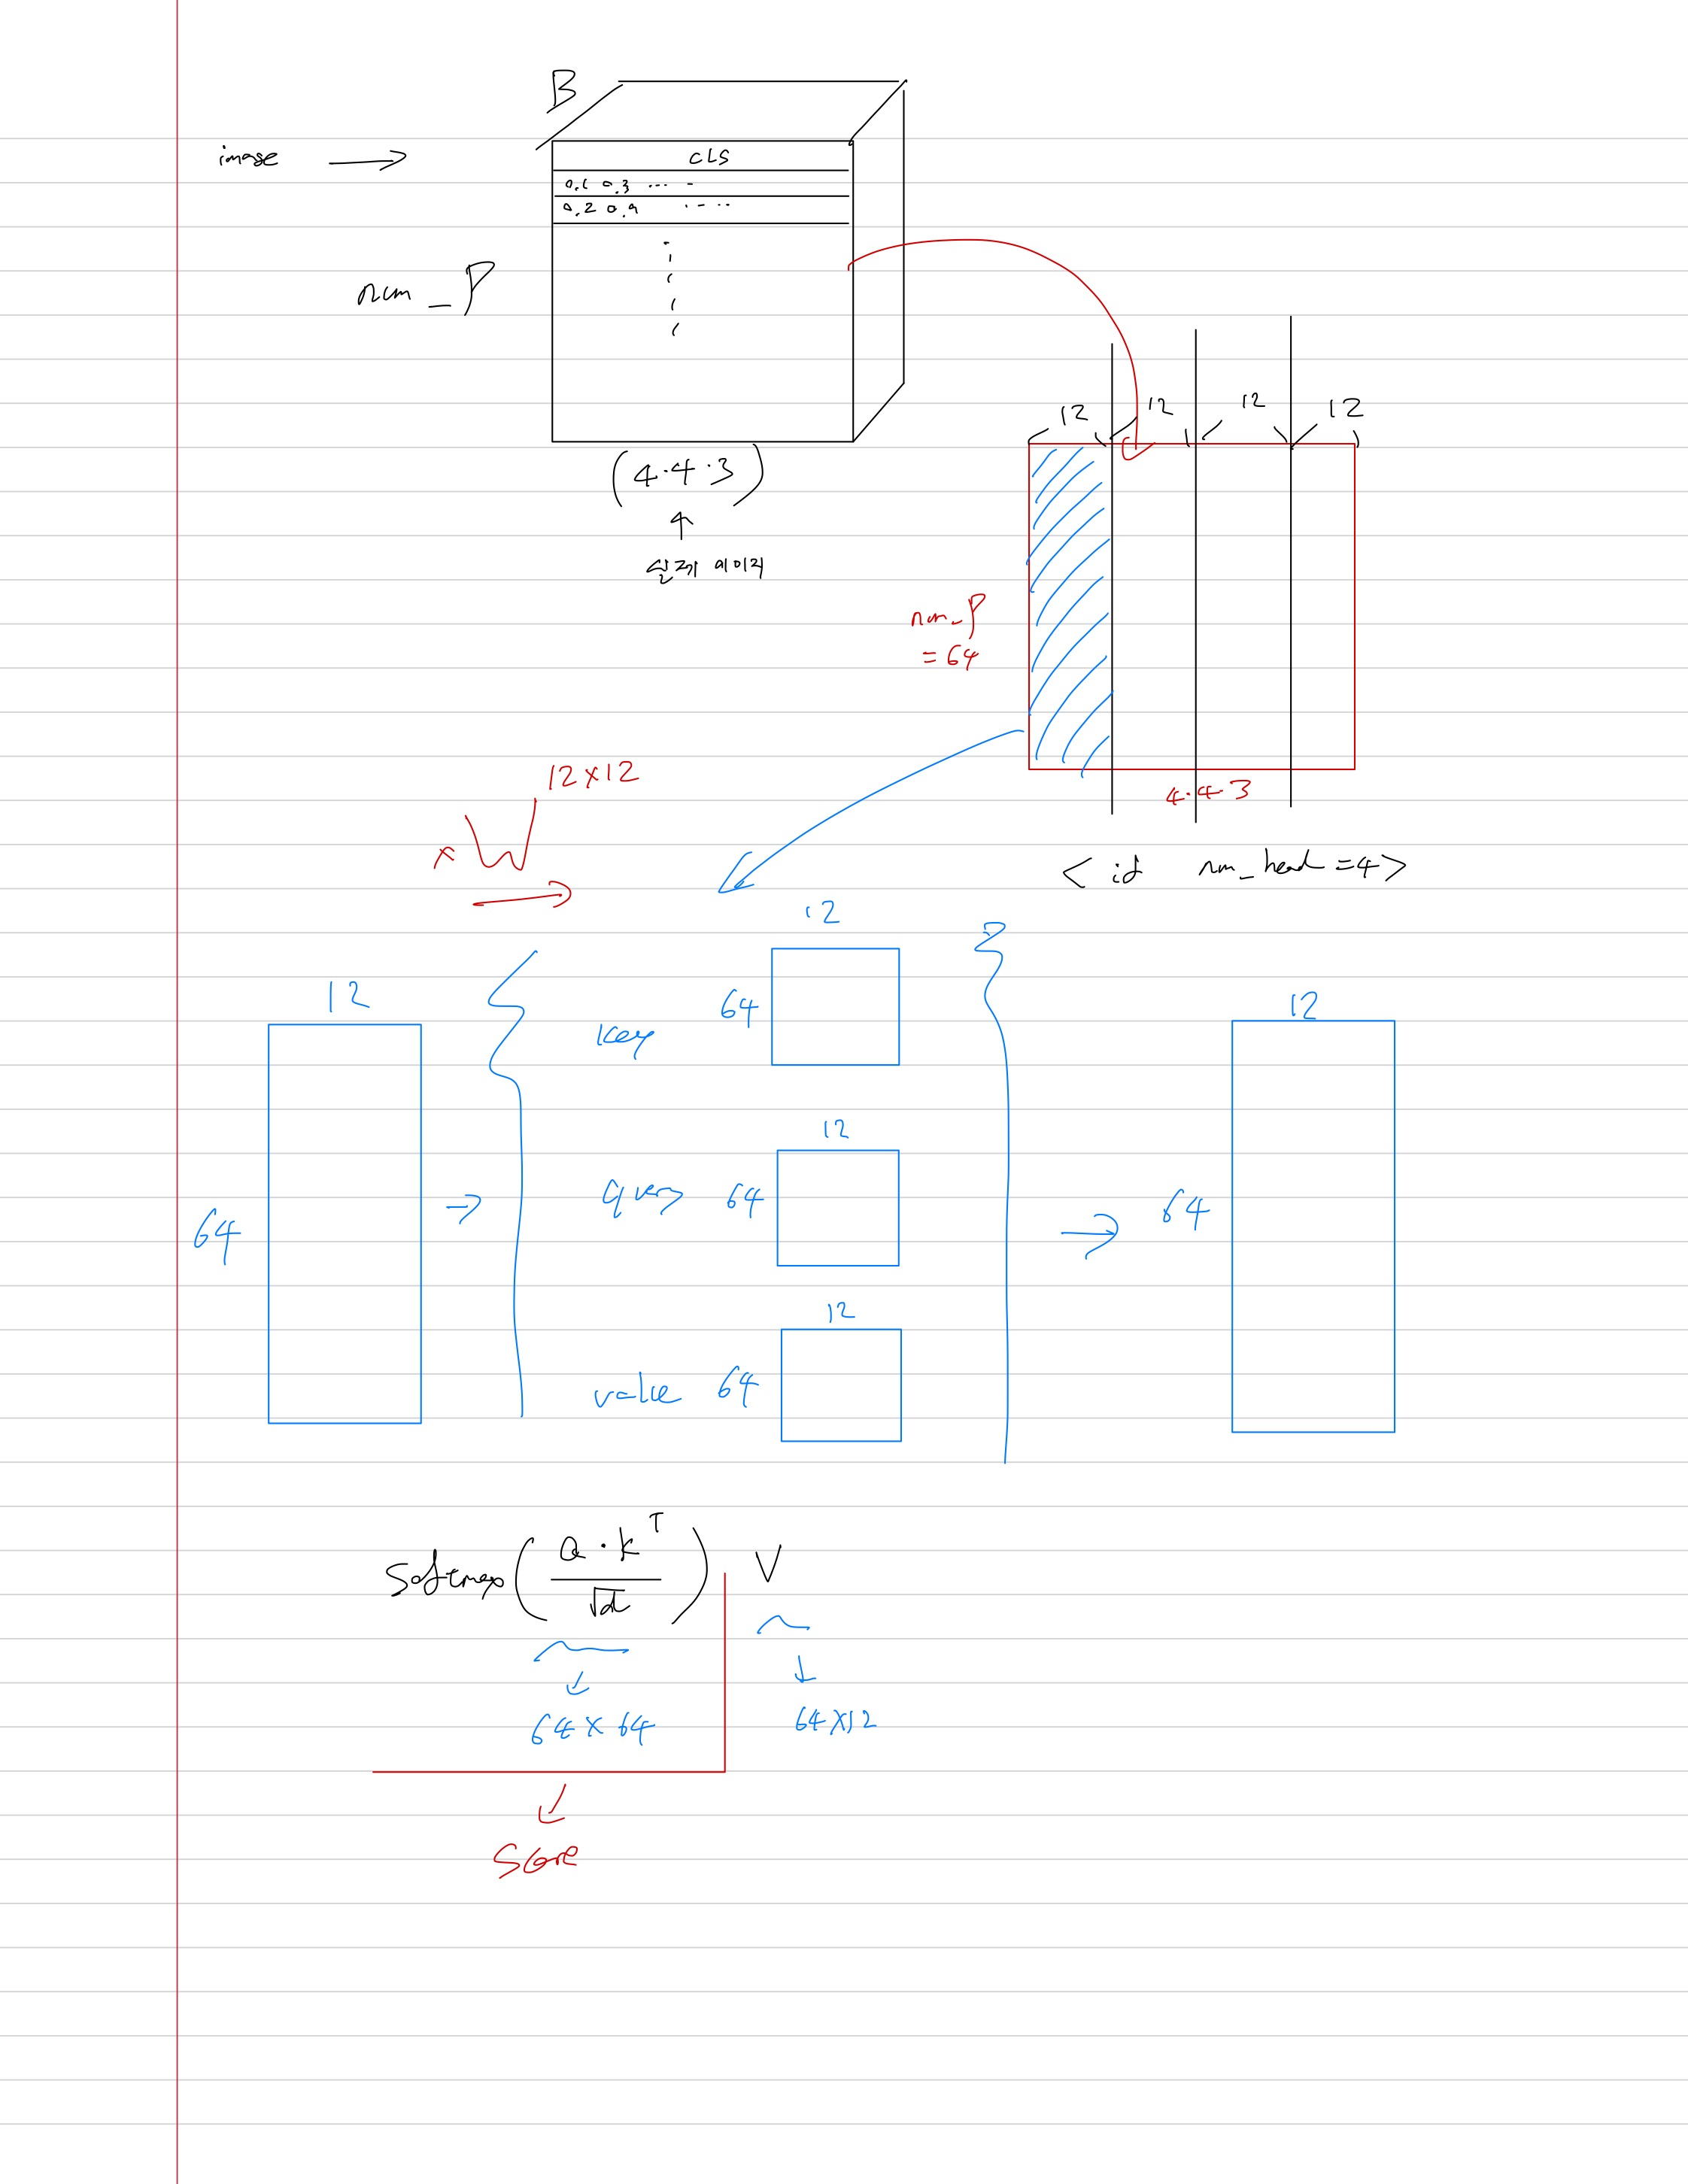

**주의**
- 자주 보는 attention map은 value 곱하기 전 score임. 그래서 정사각형 모양인거 ( 계산 다하면 입력이랑 동일하게 나옴 )
- key query value 행렬 만들고 그다음 head로 나눠줌

- Q. K transpose 시키고싶은데 어떻게 해요?
  - A. permute ㅇㅇ

- Q. torch.matmul 이거 3차원 이상일때는 어떻게 곱하는거에요?
  - A. 마지막 2차원만 곱해줌

- Q. attention_score = torch.softmax(before_softmax,dim=-1) 내가 생각하기에는 이거 돌릴때 input이 8 * n_head * 64 * 64에서, 마지막께 아니라 뒤에서 두번째꺼를 기준으로 softmax 해야할거같은데 뭐지..
  - A. torch tf 정리본 확인. 이거 dim = -1 하는게 맞음

**주의**
- 아하 !! MHA는 반드시 마지막에 linear 포함되어있어야함 !! transformer 본 논문에 그렇게 되어있네
- 나는 MLP 부분 구현할때, 그냥 1layer로만 했는데 대부분 인터넷 코드는 한번 쭉 늘렸다가 다시 축소시키는 방식으로 했음. 그렇게 하는게 더 나은듯.
- MLP 마지막에는 activation 다들 안쓰는듯

In [13]:
# input으로는 batch x num_patch+1 x (4 * 4 * 3) 가 들어감
# 여기서 layernorm을 한다고 하면, 4*4*3 측면에서 norm이겠죠? -> 이거 x에서 받아서 분석하고 마지막꺼만 뽑아서 사용하는 방식으로 진행
#     -> 이렇게 하려고 하니까 head 개수도 그러면 나중에 정해야함 그러지 말고 그냥 params로 받는걸로 하는게 좋을듯

class transformer_encoder(nn.Module):
  def __init__(self,embedding_dim=4*4*3,num_heads=4):
    super().__init__()

    self.embedding_dim = embedding_dim
    self.num_heads = num_heads

    ## 자. 입력으로는 패치 하나당 4*4*3 들어옴. 이걸 헤드로 나눠야해
    ## 만약 안나눠지면 경고띄우기
    if self.embedding_dim % self.num_heads != 0:
            raise ValueError("dim / head 안나눠짐 !!")
    self.head_dim = self.embedding_dim//self.num_heads

    ## 1. Norm
    self.bn = nn.LayerNorm(self.embedding_dim)

    ## 2. Multi head attention
    ## input : num_patch * embedding dim

    self.key = nn.Linear(self.embedding_dim,self.embedding_dim)
    self.query = nn.Linear(self.embedding_dim,self.embedding_dim)
    self.value = nn.Linear(self.embedding_dim,self.embedding_dim)

    ## input으로 batch * num_patch * patch 들어감
    ## fc1은 mha 마지막 부분용, fc2... 는 이후 mlp용
    self.fc_1 = nn.Linear(self.embedding_dim,self.embedding_dim)
    self.fc_2 = nn.Linear(self.embedding_dim,self.embedding_dim*2)
    self.fc_3 = nn.Linear(self.embedding_dim*2,self.embedding_dim)
    self.act = nn.GELU()
    self.dropout = nn.Dropout(0.3)

  def forward(self,x):
    batch_size,num_patch,__ = x.shape

    residual_x1 = x # 나중에 MHA 끝나고 더해줄거 남겨두기
    x = self.bn(x)

    # 아래 과정으로 만들어지는 k q v는 파라미터 아니고 실제 값 ㅇㅇ. 들어간대로 차원 똑같이 나옴
    K = self.key(x)  # batch * num_patch * img
    Q = self.query(x)
    V = self.value(x)

    # 헤드 사이즈로 k q v 행렬 자르기
    # 이후에 permute로 head를 앞으로 보내기

    K = K.view(batch_size, num_patch, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
    Q = Q.view(batch_size, num_patch, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, num_patch, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

    ## input이 8*64*48이었다면, 지금은 8 * 4(n_head) * 64 * 12 임.
    scale =  torch.sqrt(torch.FloatTensor([self.head_dim]))

    ## 이때 matmul은 제일 뒤에꺼 두개만 곱한대
    before_softmax = torch.matmul(K,Q.transpose(2,3)) / scale

    ## softmax. 현재 들어가는 before softmax는 k , q 곱으로 만들어진 정사각형 타입. 8 * 4 * 64 * 64
    attention_score = torch.softmax(before_softmax,dim=-1)  # 마지막 차원 기준으로 softmax

    attention = torch.matmul(attention_score,V)

    ## permutation 복귀후 붙이기
    attention = attention.permute(0,2,1,3).contiguous()
    attention = attention.view(batch_size, num_patch ,self.num_heads * self.head_dim)

    ## MHA의 마지막부분인 linear
    x = self.fc_1(attention)

    # residual connection
    x= torch.add(residual_x1,attention)
    residual_x2 = x

    # norm
    x = self.bn(x)

    # FC
    x = self.fc_2(x)
    x = self.act(x)
    x = self.dropout(x)
    x = self.fc_3(x)

    # residual connection
    #print(type(x))
    x = torch.add(residual_x2,x)
    #print(type(x))
    #print(x.shape)

    return x, attention_score

In [14]:
class mlp_head(nn.Module):
  ## input_dim에 batch * patch_num * embedding 들어가야함
  def __init__(self,input_dim=65*48,num_class=10):
    super().__init__()
    self.input_dim = input_dim
    self.num_class = num_class
    self.fc = nn.Linear(self.input_dim,self.num_class)

  def forward(self,x):
    #print(x.shape)
    x = x.view(x.size(0),-1) ## 이거 해야 배치 32*65*48을 32*3120으로 처리가능
    x = self.fc(x)
    return x

In [15]:
class VIT(nn.Module):
  def __init__(self,):
    super().__init__()
    self.input_to_embedding = input_to_embedding()
    self.transformer_encoder = transformer_encoder()
    self.mlp_head = mlp_head()

  def forward(self,x):
    x = self.input_to_embedding(x)
    #print(type(x))
    x, attention_score = self.transformer_encoder(x)
    #print(type(x))
    x = self.mlp_head(x)

    return x


In [18]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = VIT()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
early_stop_loss = float('inf')

patience = 5

for epoch in tqdm(range(100)):
  train_loss = 0.0
  val_loss = 0.0
  correct = 0.0
  total = 0.0
  model.train()

  for input,label in train_loader:
    label = label.long()
    #print(input.shape)
    #print(input)
    optimizer.zero_grad()
    output = model(input)
    #print(output.shape)
    loss = loss_fn(output,label)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  print("\ntrain loss -> ", train_loss/len(train_loader))
  model.eval()
  with torch.no_grad():
    for input,label in valid_loader:
      input = input.float()
      #print(input)
      label = label.long()
      output = model(input)
      loss = loss_fn(output,label)
      val_loss += loss.item()
      _, predicted = torch.max(output, dim=1)
      correct += (predicted == label).sum().item()
      total += label.size(0)
  print("val loss -> ", val_loss/len(valid_loader))
  print("val -> ",correct/total)

  scheduler.step(val_loss)

  if val_loss < early_stop_loss:
      early_stop_loss = val_loss
      counter = 0  # 성능 개선 시 카운터 초기화
  else:
      counter += 1
      if counter >= patience:
          print("Early stopping triggered")
          break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]


train loss ->  1.7007296011222535


  1%|          | 1/100 [03:42<6:07:13, 222.56s/it]

val loss ->  1.4339303328732775
val ->  0.4914

train loss ->  1.367955525673783


  2%|▏         | 2/100 [07:23<6:01:32, 221.35s/it]

val loss ->  1.3104371037452844
val ->  0.5276

train loss ->  1.2567494129067036


  3%|▎         | 3/100 [11:01<5:56:02, 220.23s/it]

val loss ->  1.2064634857663683
val ->  0.5666

train loss ->  1.1748826896669853


  4%|▍         | 4/100 [14:49<5:57:01, 223.14s/it]

val loss ->  1.2026120610297866
val ->  0.5672

train loss ->  1.1276866213683974


  5%|▌         | 5/100 [18:37<5:56:08, 224.93s/it]

val loss ->  1.1348674604847173
val ->  0.5952

train loss ->  1.0850193079854888


  6%|▌         | 6/100 [22:20<5:51:08, 224.14s/it]

val loss ->  1.159431451065525
val ->  0.5928

train loss ->  1.0481938176868482


  7%|▋         | 7/100 [26:13<5:52:03, 227.13s/it]

val loss ->  1.1335492859220808
val ->  0.6014

train loss ->  1.0100620881453761


  8%|▊         | 8/100 [29:53<5:44:35, 224.73s/it]

val loss ->  1.107864187401571
val ->  0.612

train loss ->  0.9692190374011425


  9%|▉         | 9/100 [33:28<5:36:31, 221.88s/it]

val loss ->  1.0794992276058075
val ->  0.6232

train loss ->  0.9496075621334136


 10%|█         | 10/100 [36:59<5:27:46, 218.52s/it]

val loss ->  1.1305072723300593
val ->  0.6038

train loss ->  0.9293925867024769


 11%|█         | 11/100 [40:35<5:22:54, 217.69s/it]

val loss ->  1.1014738713100458
val ->  0.6182

train loss ->  0.9015345288322764


 12%|█▏        | 12/100 [44:15<5:20:26, 218.48s/it]

val loss ->  1.1021324642904244
val ->  0.6166

train loss ->  0.8799377264456285


 13%|█▎        | 13/100 [47:55<5:17:14, 218.79s/it]

val loss ->  1.1062630449131037
val ->  0.6194

train loss ->  0.7135439791320145


 14%|█▍        | 14/100 [51:23<5:09:00, 215.59s/it]

val loss ->  1.0129620201268774
val ->  0.6448

train loss ->  0.6836018316611892


 15%|█▌        | 15/100 [54:49<5:01:17, 212.67s/it]

val loss ->  1.008720998931083
val ->  0.6508

train loss ->  0.6703893824320951


 16%|█▌        | 16/100 [58:10<4:52:54, 209.22s/it]

val loss ->  1.0186740945858561
val ->  0.6474

train loss ->  0.659870309446751


 17%|█▋        | 17/100 [1:01:38<4:48:52, 208.82s/it]

val loss ->  1.022132691304395
val ->  0.6508

train loss ->  0.6532523754690247


 18%|█▊        | 18/100 [1:05:09<4:46:14, 209.44s/it]

val loss ->  1.0261234735986988
val ->  0.6462

train loss ->  0.6464916026456693


 19%|█▉        | 19/100 [1:08:36<4:41:40, 208.65s/it]

val loss ->  1.0281751896165738
val ->  0.6422

train loss ->  0.621598292557839


 19%|█▉        | 19/100 [1:12:06<5:07:26, 227.73s/it]

val loss ->  1.0222792769693265
val ->  0.6486
Early stopping triggered


In [21]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for input, label in test_loader:
    output = model(input)
    _, predicted = torch.max(output, dim=1)
    correct += (predicted == label).sum().item()
    total += label.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy :.2f}%")

Accuracy: 0.66%
